In [ ]:
!pip install catboost

In [2]:
import json
from functools import partial
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

### Load data

In [4]:
dataset = pd.read_parquet("/content/drive/MyDrive/projects/Поиск_одинаковых_товаров_на_маркетплейсе/extraction/hackathon_files_for_participants_ozon/train_pairs.parquet")
etl = pd.read_parquet("/content/drive/MyDrive/projects/Поиск_одинаковых_товаров_на_маркетплейсе/extraction/hackathon_files_for_participants_ozon/train_data.parquet")

In [ ]:
dataset.head(2)

,target,variantid1,variantid2
0,0.0,51197862,51198054
1,1.0,53062686,536165289


In [ ]:
dataset["target"].value_counts()

0.0    171527
1.0    135013
Name: target, dtype: int64

In [ ]:
etl.head(2)

,variantid,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping
0,51195767,"Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485...","{""Номинальный ток, А"":[""10""],""Цвет товара"":[""о..."
1,53565809,Магнитный кабель USB 2.0 A (m) - USB Type-C (m...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...",[красный],"[[0.26863545, -0.3130674, 0.29023397, 0.073978...","[[1.1471839, -0.665361, 0.7745614, 0.26716197,...","[-0.6575592, 0.6522429, 0.5426037, -0.54347897...","{""Конструктивные особенности"":[""Магнитная конс..."


Get raw data for each variantid.

In [5]:
features = (
    dataset
    .merge(
        etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [ ]:
features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,name2,categories2,color_parsed2,pic_embeddings_resnet_v12,main_pic_embeddings_resnet_v12,name_bert_642,characteristic_attributes_mapping2
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",Удлинитель TDM Electric Люкс УЛ05В 1.5 м (SQ13...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.42941108, -0.5129398, -0.4753536, -0.0677...","[-0.455473, 0.58157134, 0.5870387, -0.5325003,...","{""Электробезопасность"":[""Заземление""],""Длина к..."
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",Удлинитель TDM Electric Люкс УЛ05В 3 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.43180764, -0.49580905, -0.5062628, -0.130...","[-0.5425725, 0.6415736, 0.51481575, -0.5687392...","{""Макс. нагрузка, Вт"":[""3500""],""Стандарт защит..."


Features functions.

In [6]:
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                     metric,
                     percentiles: List[int]):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
    
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:
        main_pic_embeddings_1 = np.array([x for x in main_pic_embeddings_1])
        main_pic_embeddings_2 = np.array([x for x in main_pic_embeddings_2])
        
        dist_m = pairwise_distances(
            main_pic_embeddings_1, main_pic_embeddings_2,
            metric=metric
        )
    else:
        dist_m = np.array([[-1]])

    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()

    return pair_features


def text_dense_distances(ozon_embedding, comp_embedding):
    """Calculate Euclidean and Cosine distances between
    ozon_embedding and comp_embedding.
    """
    pair_features = []
    if ozon_embedding is None or comp_embedding is None:
        pair_features = [-1, -1]
    elif len(ozon_embedding) == 0 or len(comp_embedding) == 0:
        pair_features = [-1, -1]
    else:
        pair_features.append(
            euclidean(ozon_embedding, comp_embedding)
        )
        cosine_value = cosine(ozon_embedding, comp_embedding)
        
        pair_features.append(cosine_value)

    return pair_features


In [7]:
get_pic_features_func = partial(
    get_pic_features,
    percentiles=[0, 25, 50]
)

In [8]:
features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
    features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x, metric='euclidean')), axis=1
    )
)

# btw try to add distances between main pic embs

features[["pic_dist_0_perc_main", "pic_dist_25_perc_main", "pic_dist_50_perc_main"]] = (
    features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x, metric='euclidean')), axis=1
    )
)

In [9]:
# added cosine distances

features[["cos_pic_dist_0_perc", "cos_pic_dist_25_perc", "cos_pic_dist_50_perc"]] = (
    features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x, metric='cosine')), axis=1
    )
)

features[["cos_dist_0_perc_main", "cos_dist_25_perc_main", "cos_dist_50_perc_main"]] = (
    features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x, metric='cosine')), axis=1
    )
)

In [ ]:
features.sample(5)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,pic_dist_50_perc,pic_dist_0_perc_main,pic_dist_25_perc_main,pic_dist_50_perc_main,cos_pic_dist_0_perc,cos_pic_dist_25_perc,cos_pic_dist_50_perc,cos_dist_0_perc_main,cos_dist_25_perc_main,cos_dist_50_perc_main
119535,0.0,811261266,811261376,Кабельная сборка 50 Ом на RG-58 с разъемами F-...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...",[черный],None,"[[1.3970108, -0.68204015, 0.69205105, -1.15554...","[-0.65629894, 0.4272643, 0.6539782, -0.4555335...","{""Длина, м"":[""25""],""Коннектор 2"":[""F""],""Тип ко...",...,-1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000e+00,-1.000000,0.000000,0.000000,0.000000
66956,0.0,137931865,317403971,"15.6"" Ноутбук HUAWEI MateBook D-15, Intel Core...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Компьют...","[grey, серый]","[[-0.8600922, -0.0071902573, 0.34269443, 0.119...","[[1.040806, -0.42697483, -0.8742407, -0.689346...","[-0.1398493, 0.53643125, 0.6503502, -0.6345407...","{""Кол-во элементов аккумулятора"":[""4""],""Видеок...",...,6.203391,0.034596,0.034596,0.034596,0.000007,2.252870e-01,0.422487,0.000008,0.000008,0.000008
200774,0.0,97749682,247882991,Аккумулятор 18650 Li-ion 18650B 2200mAh - 2 штуки,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Батарей...",[голубой],"[[-0.3240595, -0.696632, 0.25966695, 0.1673728...","[[-0.4632642, -0.76476073, -0.34398225, 0.5431...","[-0.40853158, 0.44314775, 0.78295463, -0.38112...","{""Комплектация"":[""Аккумулятор 18650 Li-ion - 2...",...,1.311448,0.044137,0.044137,0.044137,0.000000,1.341105e-07,0.054798,0.000033,0.000033,0.000033
81257,0.0,243693455,746266064,Системный блок Lenovo Legion T5 26AMR5 (AMD Ry...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Компьют...",[черный],None,"[[0.35610244, -0.5913585, -0.16004007, 0.16131...","[-0.31844792, 0.38310745, 0.7481327, -0.677510...","{""Видеокарта"":[""NVIDIA GeForce RTX 3070 (8 Гб)...",...,-1.000000,1.765736,1.765736,1.765736,-1.000000,-1.000000e+00,-1.000000,0.048568,0.048568,0.048568
233240,1.0,85974860,558953064,Ремешок силиконовый GSMIN Italian Collection 2...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смарт-ч...","[зеленый, бирюзовый]","[[0.7150238, -0.42997256, 0.3940751, -0.317397...","[[0.29076743, -0.43179855, 0.44123325, 0.51521...","[-0.5783164, 0.5299836, 0.672151, -0.11095748,...","{""Материал браслета/ремешка"":[""Силикон""],""Разм...",...,7.638934,0.176014,0.176014,0.176014,0.000021,1.450246e-01,0.676329,0.000297,0.000297,0.000297


In [10]:
features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

# try to use your favorite NLP model

In [11]:
features["cat3"] = features["categories1"].apply(lambda x: json.loads(x)["3"])
cat3_counts = features["cat3"].value_counts().to_dict()

Let's find good cat size threshold

In [12]:
cntr = 0
for cat3 in cat3_counts:
    if cat3_counts[cat3] < 1_000:
        cntr += cat3_counts[cat3]
        
cntr

10765

10k for "rest" cats probably is good

In [13]:
features["cat3_grouped"] = features["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
lb = LabelEncoder()
features['cat3'] = lb.fit_transform(features['cat3'])

In [ ]:
features.head(5)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,cos_dist_0_perc_main,cos_dist_25_perc_main,cos_dist_50_perc_main,euclidean_name_bert_dist,cosine_name_bert_dist,cat3,cat3_grouped,cos_pic_dist_0_perc,cos_pic_dist_25_perc,cos_pic_dist_50_perc
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,0.000387,0.000387,0.000387,0.338458,0.003606,60,"Сетевые фильтры, разветвители и удлинители",-1.0,-1.0,-1.0
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,0.000456,0.000456,0.000456,0.475419,0.007311,60,"Сетевые фильтры, разветвители и удлинители",-1.0,-1.0,-1.0
2,1.0,53062686,536165289,Картридж лазерный Комус 729 (4370B002) черный ...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...","[черный, чер]",None,"[[-0.0032773763, 0.32531193, -0.33156675, 0.41...","[-0.53706163, 0.37264067, 0.44363657, -0.37289...","{""Количество в упаковке, шт"":[""1""],""Бренд"":[""К...",...,0.012371,0.012371,0.012371,0.577868,0.010588,54,Расходник для печати,-1.0,-1.0,-1.0
3,1.0,53602615,587809782,Картридж лазерный Комус 729 (4368B002) пурпурн...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",[пурпурный],None,"[[0.027616128, 0.33428708, -0.37326592, 0.4108...","[-0.61162275, 0.4953002, 0.47400212, -0.429568...","{""Назначение"":[""для лазерного принтера""],""Совм...",...,0.011430,0.011430,0.011430,0.491225,0.007455,54,Расходник для печати,-1.0,-1.0,-1.0
4,1.0,53602615,615149925,Картридж лазерный Комус 729 (4368B002) пурпурн...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",[пурпурный],None,"[[0.027616128, 0.33428708, -0.37326592, 0.4108...","[-0.61162275, 0.4953002, 0.47400212, -0.429568...","{""Назначение"":[""для лазерного принтера""],""Совм...",...,0.010815,0.010815,0.010815,0.451149,0.006258,54,Расходник для печати,-1.0,-1.0,-1.0


Choose features

In [16]:

feats = ["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc", 'pic_dist_0_perc_main', 
         'pic_dist_25_perc_main', 'pic_dist_50_perc_main', 'cos_dist_0_perc_main',	
         'cos_dist_25_perc_main',	'cos_dist_50_perc_main', 'cos_pic_dist_0_perc', 'cos_pic_dist_25_perc','cos_pic_dist_50_perc',
         "euclidean_name_bert_dist", "cosine_name_bert_dist", 'cat3']

Split dataset

In [17]:
X_train, X_test = train_test_split(
    features[feats + ["target", "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=features[["target", "cat3_grouped"]]
)

X_train, X_val = train_test_split(
    X_train[feats + ["target",  "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=X_train[["target", "cat3_grouped"]]
)

y_test = X_test[["target", "variantid1", "variantid2"]]
X_test = X_test.drop(["target"], axis=1)

y_train = X_train["target"]
y_val = X_val["target"]

X_train = X_train.drop(["target"], axis=1)
X_val = X_val.drop(["target"], axis=1)

train_pool = Pool(
    data=X_train[feats],
    label=y_train,
)
eval_pool = Pool(
    data=X_val[feats],
    label=y_val,
)

In [18]:
model = CatBoostClassifier(iterations=2000, depth=13, l2_leaf_reg=1,
                           learning_rate=0.1, bootstrap_type='Bernoulli', 
                           task_type='GPU')
model.fit(
    train_pool,
    eval_set=eval_pool,
    verbose=True,
    use_best_model=True,
    early_stopping_rounds=50,
    metric_period=100
)

0:	learn: 0.6569432	test: 0.6566078	best: 0.6566078 (0)	total: 225ms	remaining: 7m 29s
100:	learn: 0.4498858	test: 0.4674730	best: 0.4674730 (100)	total: 11.6s	remaining: 3m 38s
200:	learn: 0.4149701	test: 0.4600841	best: 0.4600841 (200)	total: 23s	remaining: 3m 25s
300:	learn: 0.3878139	test: 0.4577473	best: 0.4576899 (299)	total: 34.4s	remaining: 3m 13s
400:	learn: 0.3657557	test: 0.4570175	best: 0.4569728 (397)	total: 44.8s	remaining: 2m 58s
bestTest = 0.4569727745
bestIteration = 397
Shrink model to first 398 iterations.


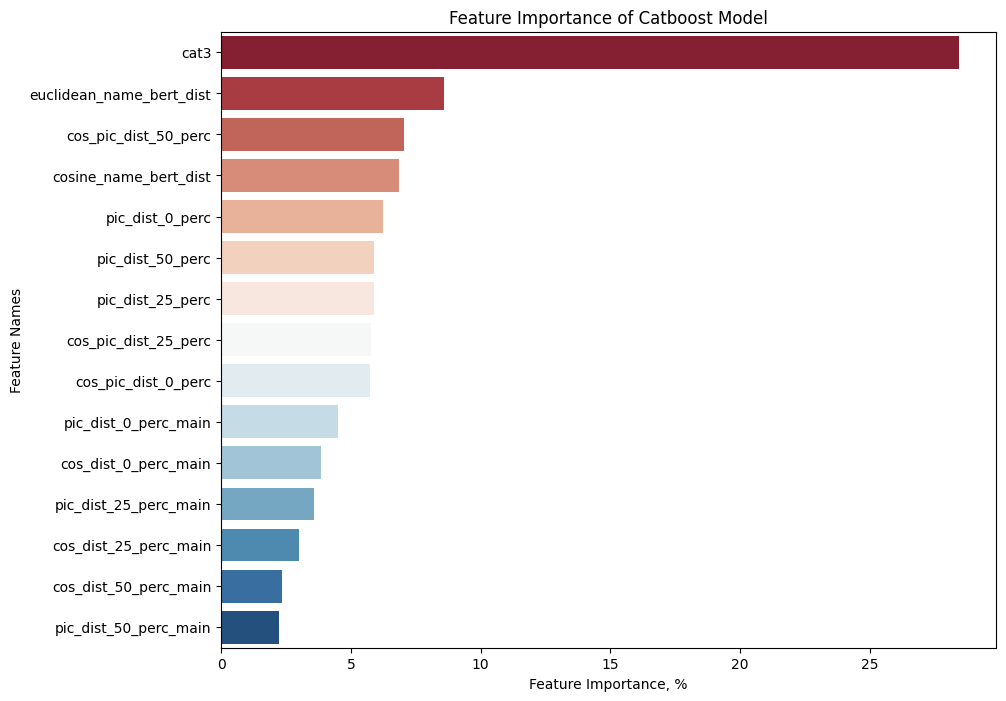

In [19]:
def plot_important_features(ft_import, names, model):
  f_importance = np.array(ft_import)
  f_names = np.array(names)
  d = {'feature_importance': f_importance, 'feature_names': f_names}
  df = pd.DataFrame(d)
  df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
  plt.figure(figsize=[10,8])
  sns.barplot(x=df['feature_importance'], y=df['feature_names'], palette='RdBu')
  plt.ylabel('Feature Names')
  plt.xlabel('Feature Importance, %')
  plt.title(f'Feature Importance of {model} Model')
  plt.show()

plot_important_features(model.feature_importances_,X_train[feats].columns, 'Catboost')

### Metric

In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc

def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:

    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])

    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]

    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    # calculate metric for each big category
    for i, category in enumerate(unique_cats):
        # take just a certain category
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        # if there is no matches in the category then PRAUC=0
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # get coordinates (x, y) for (recall, precision) of PR-curve
        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)
        
        # reverse the lists so that x's are in ascending order (left to right)
        y = y[::-1]
        x = x[::-1]
        
        # get indices for x-coordinate (recall) where y-coordinate (precision) 
        # is higher than precision level (75% for our task)
        good_idx = np.where(y >= prec_level)[0]
        
        # if there are more than one such x's (at least one is always there, 
        # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
        # with acceptable precision
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        # if there is only one such x, then we have zeros in the top scores 
        # and the curve simply goes down sharply at x=0 and does not rise 
        # above the required precision: PRAUC=0
        else:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # calculate category weight anyway
        weights.append(counts[i] / len(categories))
        # calculate PRAUC for all points where the rightest x 
        # still has required precision 
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
        except ValueError:
            pr_aucs.append(0)
            
    return np.average(pr_aucs, weights=weights)

In [21]:
X_test["scores"] = model.predict_proba(X_test[feats])[:, 1]

In [22]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped"
)

pr_auc_macro_metr

0.39467225553127583

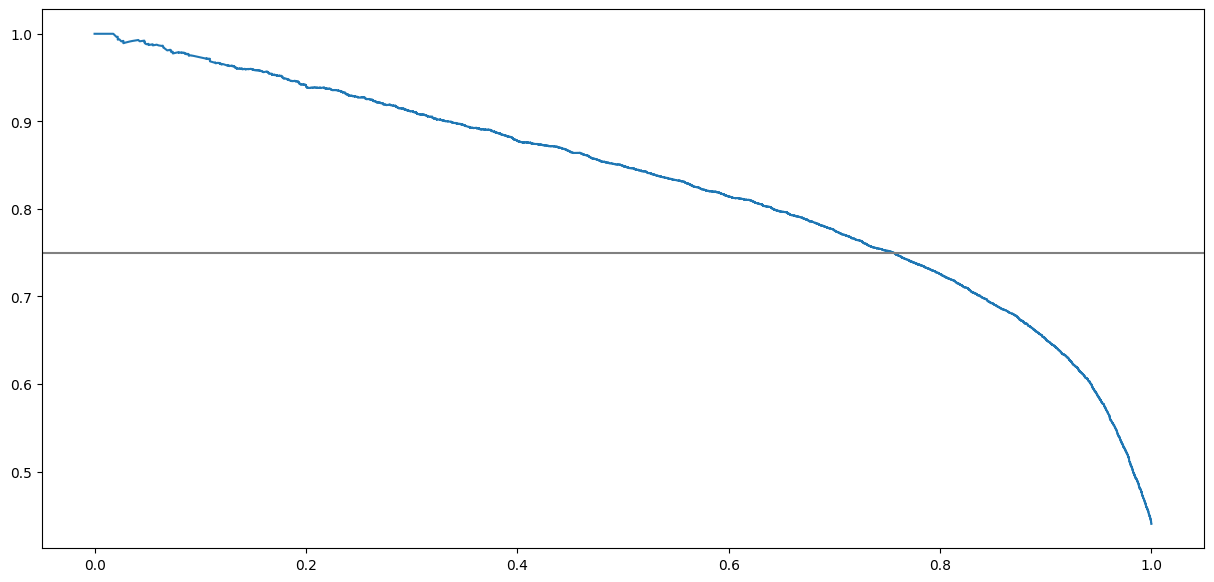

In [23]:
precision, recall, thrs = precision_recall_curve(y_test["target"], X_test["scores"])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

### Recommendations 

- Work with names, in electronics names often contain a lot of useful information for matching.
- Don't forget about attributes: working with it will allow your model to better distinguish matches from non-matches.